# Analysis & Testing
Client & Author's Orders + Hypothesis Testing

In [1]:
import required_dataframes as rd
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, boxcox
import pingouin as pg

## 1. Client Oder #1
### “Top Five Romance Authors”

In [39]:
# Read from MySQL database

df1 = rd.request_one()
df1.head()

/Users/kvmmn/Desktop/data_summit/quda/quda_projects/Book-Store/kaveh_analysis/required_dataframes.py:68: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


,name,num_of_romance_books,avg_grade,num_of_awards_tags,num_of_list_tags,description
0,جین آستین,995,3.5970,NaN,3240.0,جین آستین، زاده ی ۱۶ دسامبر ۱۷۷۵ و درگذشته ی ۱...
1,امیلی برونته,761,3.5506,NaN,3820.0,امیلی برونته، در ۲۱ آوریل ۱۸۱۸ در تورنتن (براد...
2,شارلوت برونته,614,3.5179,NaN,3533.0,شارلوت برونته، زاده ی ۲۱ آوریل ۱۸۱۶ و درگذشته ...
3,الیف شافاک,435,3.8092,230.0,808.0,None
4,جین وبستر,367,3.4251,NaN,227.0,جین وبستر، زاده ی 24 جولای 1876 و درگذشته ی 11...


In [40]:
# Handle missing values in numerical columns: Null -> 0

df1 = df1.fillna(0)

df1.isnull().sum()

name                    0
num_of_romance_books    0
avg_grade               0
num_of_awards_tags      0
num_of_list_tags        0
description             0
dtype: int64

In [4]:
# Normalize numerical values to the range (1, 2)

cols_to_scale = [
    "num_of_romance_books",
    "avg_grade",
    "num_of_awards_tags",
    "num_of_list_tags",
]
min_max_scaler = MinMaxScaler(feature_range=(1, 2))
df1[cols_to_scale] = min_max_scaler.fit_transform(df1[cols_to_scale])

df1.head()

,name,num_of_romance_books,avg_grade,num_of_awards_tags,num_of_list_tags,description
0,جین آستین,2.000000,1.532333,1.0,1.848168,جین آستین، زاده ی ۱۶ دسامبر ۱۷۷۵ و درگذشته ی ۱...
1,امیلی برونته,1.764588,1.516867,1.0,2.000000,امیلی برونته، در ۲۱ آوریل ۱۸۱۸ در تورنتن (براد...
2,شارلوت برونته,1.616700,1.505967,1.0,1.924869,شارلوت برونته، زاده ی ۲۱ آوریل ۱۸۱۶ و درگذشته ...
3,الیف شافاک,1.436620,1.603067,2.0,1.211518,0
4,جین وبستر,1.368209,1.475033,1.0,1.059424,جین وبستر، زاده ی 24 جولای 1876 و درگذشته ی 11...


### Metric for client order 1
metric_1 = f1 × f2<sup>2</sup> × f3<sup>3</sup> × f4 <br><br>
f1 = Author's Romance Books Count <br>
f2 = Average Rating of Author's Romance Books <br>
f3 = Number of Awards For Author's Romance Books <br>
f4 = Number of Listings For Author's Romance Books

In [5]:
# Compute the final metric for each author
# Approach:
#   Very strong Rating effect
#   Strong number of books effect

df1["metric_1"] = round(
    df1["num_of_romance_books"] ** 2
    * df1["avg_grade"] ** 3
    * df1["num_of_awards_tags"]
    * df1["num_of_list_tags"],
    2,
)

top_writers = (
    df1[["name", "metric_1"]].sort_values(by="metric_1", ascending=False).head(5)
)

print(f"Top 5 writers are: ")
display(top_writers)

Top 5 writers are: 


,name,metric_1
0,جین آستین,26.60
1,امیلی برونته,21.73
3,الیف شافاک,20.60
2,شارلوت برونته,17.18
8,گابریل گارسیا مارکز,9.82


------------------------------------------------

## 2. Client Oder #2
### “Books With Best Quality & Price”

In [41]:
# Read from MySQL database

df2 = rd.request_two()
df2

/Users/kvmmn/Desktop/data_summit/quda/quda_projects/Book-Store/kaveh_analysis/required_dataframes.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


,code,title_persian,title_english,price,release_year_mi,release_year_sh,grade,page_count,cover,num_of_award_tags,num_of_list_tags
0,24,زندگی پی,Life of Pi,295000,2001.0,1396.0,4,532.0,شومیز,3.0,16.0
1,26,هرگز ترکم مکن,Never Let Me Go,285000,2005.0,1402.0,4,328.0,شومیز,12.0,30.0
2,28,بودا در اتاق زیرشیروانی,The Buddha in the Attic,22000,2011.0,1398.0,4,143.0,شومیز,2.0,3.0
3,30,خدای چیزهای کوچک,The God of Small Things,550000,1997.0,1387.0,4,456.0,جلدسخت,1.0,10.0
4,31,بازمانده ی روز,The Remains of the Day,235000,1989.0,1401.0,4,360.0,جلدسخت,8.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...
78631,122641,Its OK That You're Not OK,None,220000,2017.0,1402.0,0,308.0,شومیز,NaN,NaN
78632,122643,Moon Spells,None,170000,2002.0,1402.0,0,216.0,شومیز,NaN,NaN
78633,122647,All Your Perfects,None,215000,2018.0,1402.0,4,304.0,شومیز,NaN,NaN
78634,122668,دانشنامه جواهرات,Gemstones,250000,1994.0,1396.0,4,204.0,شومیز,NaN,NaN


In [42]:
# Handle missing values in important columns

# Null -> 0 :: (Hard = 1, Soft = 0)
df2["cover"] = df2["cover"].fillna("نرم")

# Null -> Mean of the page counts
df2["page_count"] = df2["page_count"].fillna(df2["page_count"].mean())

# Null -> Median of the release years shamsi
df2["release_year_sh"] = df2["release_year_sh"].fillna(df2["release_year_sh"].median())

# Null -> 0
df2["num_of_award_tags"] = df2["num_of_award_tags"].fillna(0)

# Null -> 0
df2["num_of_list_tags"] = df2["num_of_list_tags"].fillna(0)

df2.isnull().sum()

code                     0
title_persian            0
title_english          782
price                    0
release_year_mi      35981
release_year_sh          0
grade                    0
page_count               0
cover                    0
num_of_award_tags        0
num_of_list_tags         0
dtype: int64

In [43]:
# Assign cover type: f2
# Hard = 1 / covers including text "سخت" or "زرکوب" or "چرم"
# Soft = 0 / covers including text "نرم" or "سلفونی" or "شومیز"

def cover_type(cover):
    if "سخت" in cover or "زرکوب" in cover or "چرم" in cover:
        return 1
    else:
        return 0

df2["cover"] = df2["cover"].apply(cover_type)

df2["cover"].value_counts()

cover
0    71555
1     7081
Name: count, dtype: int64

In [44]:
# Assign page count type: f3
# Short = 1, Medium = 3, Long = 5

page_bins = [
    0,
    df2["page_count"].quantile(0.25),
    df2["page_count"].quantile(0.75),
    df2["page_count"].max() + 1,
]
page_labels = [1, 3, 5]
df2["page_count"] = pd.cut(
    df2["page_count"], bins=page_bins, labels=page_labels, include_lowest=True
)

df2["page_count"] = df2["page_count"].astype(float)

df2["page_count"].value_counts()

page_count
3.0    39339
1.0    19707
5.0    19590
Name: count, dtype: int64

In [45]:
# Assign publish shamsi year type: F4
# Classic = 1, Old = 3, Modern = 5

year_bins = [
    0,
    df2["release_year_sh"].quantile(0.33),
    df2["release_year_sh"].quantile(0.66),
    df2["release_year_sh"].max() + 1,
]
year_labels = [1, 3, 5]
df2["release_year_sh"] = pd.cut(
    df2["release_year_sh"], bins=year_bins, labels=year_labels, include_lowest=True
)

df2["release_year_sh"] = df2["release_year_sh"].astype(float)

df2["release_year_sh"].value_counts()

release_year_sh
3.0    28763
1.0    27030
5.0    22843
Name: count, dtype: int64

In [46]:
# Normalize numerical values to the range (1, 2)

cols_to_scale_2 = [
    "grade",
    "cover",
    "page_count",
    "release_year_sh",
    "num_of_award_tags",
    "num_of_list_tags",
]
standard_scaler = StandardScaler()
df2[cols_to_scale_2] = standard_scaler.fit_transform(df2[cols_to_scale_2])

df2.head()

,code,title_persian,title_english,price,release_year_mi,release_year_sh,grade,page_count,cover,num_of_award_tags,num_of_list_tags
0,24,زندگی پی,Life of Pi,295000,2001.0,-1.191484,0.940742,1.416699,-0.314577,1.969156,1.302229
1,26,هرگز ترکم مکن,Never Let Me Go,285000,2005.0,1.325502,0.940742,1.416699,-0.314577,8.206124,2.539961
2,28,بودا در اتاق زیرشیروانی,The Buddha in the Attic,22000,2011.0,0.067009,0.940742,0.002105,-0.314577,1.276160,0.152906
3,30,خدای چیزهای کوچک,The God of Small Things,550000,1997.0,-1.191484,0.940742,1.416699,3.178869,0.583164,0.771772
4,31,بازمانده ی روز,The Remains of the Day,235000,1989.0,1.325502,0.940742,1.416699,3.178869,5.434139,1.655867


### Metric for client order 2
metric_2 = w1×f1 + w2×f2 + w3×f3 + w4×f4 + w5×f5 + w6×f6

f1 = Rating  <br>
f2 = Cover Type (Soft or Hard) <br>
f3 = Pages Count <br>
f4 = Shamsi Year of Publishin <br>
f5 = Number of Awards <br>
f6 = Number of Listings

In [47]:
# Weights for each feature

w1 = 40
w2 = 5
w3 = 5
w4 = 5
w5 = 23
w6 = 22

In [48]:
# Compute the final metric for each book

df2["metric_2"] = (
    w1 * df2["grade"]
    + w2 * df2["cover"]
    + w3 * df2["page_count"]
    + w4 * df2["release_year_sh"]
    + w5 * df2["num_of_award_tags"]
    + w6 * df2["num_of_list_tags"]
)

df2.head()

,code,title_persian,title_english,price,release_year_mi,release_year_sh,grade,page_count,cover,num_of_award_tags,num_of_list_tags,metric_2
0,24,زندگی پی,Life of Pi,295000,2001.0,-1.191484,0.940742,1.416699,-0.314577,1.969156,1.302229,111.122504
1,26,هرگز ترکم مکن,Never Let Me Go,285000,2005.0,1.325502,0.940742,1.416699,-0.314577,8.206124,2.539961,294.387802
2,28,بودا در اتاق زیرشیروانی,The Buddha in the Attic,22000,2011.0,0.067009,0.940742,0.002105,-0.314577,1.276160,0.152906,69.117982
3,30,خدای چیزهای کوچک,The God of Small Things,550000,1997.0,-1.191484,0.940742,1.416699,3.178869,0.583164,0.771772,85.041857
4,31,بازمانده ی روز,The Remains of the Day,235000,1989.0,1.325502,0.940742,1.416699,3.178869,5.434139,1.655867,228.649288


In [14]:
# Filter books based on the criteria:
# top quality (based on the final metric) and bottom 20% prices

threshold_price = df2["price"].quantile(0.2)
threshold_metric = df2["metric_2"].quantile(0.75)

recommended_books = df2[
    (df2["price"] <= threshold_price) & (df2["metric_2"] >= threshold_metric)
]

print(f"Best recommended books are: ")
display(recommended_books)

Best recommended books are: 


,code,title_persian,title_english,price,release_year_mi,release_year_sh,grade,page_count,cover,num_of_award_tags,num_of_list_tags,metric_2
2,28,بودا در اتاق زیرشیروانی,The Buddha in the Attic,22000,2011.0,0.067009,0.940742,0.002105,-0.314577,1.276160,0.152906,69.117982
28,65,مرسو چه کسی را کشت؟,The Meursault Investigation,9000,2013.0,-1.191484,0.940742,0.002105,-0.314577,1.969156,0.152906,78.764435
36,74,شبح آنیل,Anil's Ghost,24000,2000.0,0.067009,0.940742,0.002105,-0.314577,1.969156,-0.023912,81.166885
58,100,عنکبوت,The Spider,15000,1938.0,-1.191484,0.940742,0.002105,-0.314577,0.583164,-0.112322,41.051576
69,118,همدرد,The Sympathizer,25000,2015.0,-1.191484,0.940742,1.416699,-0.314577,5.434139,0.948591,183.037065
...,...,...,...,...,...,...,...,...,...,...,...,...
78256,121663,بازی مازی با مازهای حواستو جمع کن 4 (آسان),The Megatastic Activity Book,24000,2011.0,1.325502,0.940742,-1.412490,-0.314577,-0.109833,-0.023912,32.569623
78257,121666,بازی مازی با مازهای حواستو جمع کن 7 (متوسط),The Megatastic Activity Book,24000,2011.0,1.325502,0.940742,-1.412490,-0.314577,-0.109833,-0.023912,32.569623
78399,121863,مشاهیر کتابشناسی معاصر ایران (34),Iranian contemporary bibliographic celebrities,25000,NaN,1.325502,0.940742,-1.412490,-0.314577,-0.109833,-0.023912,32.569623
78400,121865,مشاهیر کتابشناسی معاصر ایران (35),Iranian contemporary bibliographic celebrities,25000,NaN,1.325502,0.940742,-1.412490,-0.314577,-0.109833,-0.023912,32.569623


------------------------------------------------

## 3. Author's Order
### “Top Five Historical Book Publishers”

In [49]:
# Read from MySQL database

df3 = rd.request_three()
df3.head()

/Users/kvmmn/Desktop/data_summit/quda/quda_projects/Book-Store/kaveh_analysis/required_dataframes.py:147: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


,name,num_of_historic_books,avg_grade,num_of_award_tags,num_of_list_tags
0,افق,754,3.5186,106.0,2078.0
1,نگاه,719,3.5299,219.0,1554.0
2,قدیانی,704,3.4986,2.0,1222.0
3,علمی و فرهنگی,497,3.5091,55.0,989.0
4,امیرکبیر,490,3.6714,173.0,1154.0


In [50]:
# Handle missing values in numerical columns: Null -> 0

df3 = df3.fillna(0)

df3.isnull().sum()

name                     0
num_of_historic_books    0
avg_grade                0
num_of_award_tags        0
num_of_list_tags         0
dtype: int64

In [51]:
# Normalize numerical values to the range (1, 2)

cols_to_scale_3 = [
    "num_of_historic_books",
    "avg_grade",
    "num_of_award_tags",
    "num_of_list_tags",
]
min_max_scaler = MinMaxScaler(feature_range=(1, 2))
df3[cols_to_scale] = min_max_scaler.fit_transform(df3[cols_to_scale_3])

df3.head()

,name,num_of_historic_books,avg_grade,num_of_award_tags,num_of_list_tags,num_of_romance_books,num_of_awards_tags
0,افق,754,1.629650,106.0,2.000000,2.000000,1.484018
1,نگاه,719,1.632475,219.0,1.747834,1.953519,2.000000
2,قدیانی,704,1.624650,2.0,1.588065,1.933599,1.009132
3,علمی و فرهنگی,497,1.627275,55.0,1.475938,1.658699,1.251142
4,امیرکبیر,490,1.667850,173.0,1.555342,1.649402,1.789954


### Metric for Author's order
metric_3 = f1 × f2<sup>2</sup> × f3<sup>3</sup> × f4 <br><br>
f1 = Number of Historical Books By Publisher <br>
f2 = Average Rating of Publisher's Historical Books <br>
f3 = Number of Awards For Publisher's Historical Books <br>
f4 = Number of Listings For Publisher's Historical Books

In [52]:
# Compute the final metric for each publisher
# Approach:
#   Very strong Rating effect
#   Strong number of books effect

df3["metric_3"] = round(
    df3["num_of_historic_books"] ** 2
    * df3["avg_grade"] ** 3
    * df3["num_of_award_tags"]
    * df3["num_of_list_tags"],
    2,
)

top_publishers = (
    df3[["name", "metric_3"]].sort_values(by="metric_3", ascending=False).head(5)
)

print(f"Top 5 publishers are: ")
display(top_publishers)

Top 5 publishers are: 


,name,metric_3
1,نگاه,8.608784e+08
0,افق,5.216288e+08
4,امیرکبیر,2.997333e+08
8,روزگار,1.960519e+08
6,ققنوس,1.374197e+08


------------------------------------------------

## 4. Hypothesis #1
### “Translation has a significant impact on the book’s price.”

Null Hypothesis (H<sub>0</sub>): Translation has no significant impact on the book's price. <br>
Alternative Hypothesis (H<sub>a</sub>): Translation has a significant impact on the book's price.

In [220]:
# Read from MySQL database

df_translated, df_not_translated = rd.hypothesis_one()

df_translated.head(), df_not_translated.head()

/Users/kvmmn/Desktop/data_summit/quda/quda_projects/Book-Store/kaveh_analysis/required_dataframes.py:162: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  not_translated_df = pd.read_sql(query, conn)
/Users/kvmmn/Desktop/data_summit/quda/quda_projects/Book-Store/kaveh_analysis/required_dataframes.py:174: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  translated_df = pd.read_sql(query, conn)


(     code     price
 0  115600  12000000
 1   69010  12000000
 2   44167   8400000
 3   62672   6200000
 4   14492   5500000,
      code     price
 0   60399  12000000
 1   35689   7000000
 2   60391   6850000
 3  116285   6000000
 4   84213   5140000)

In [221]:
# Remove unnecessary column
df_translated = df_translated[['price']]
df_not_translated = df_not_translated[['price']]

In [222]:
df_translated

,price
0,12000000
1,12000000
2,8400000
3,6200000
4,5500000
...,...
43320,500
43321,417
43322,320
43323,300


Text(0.5, 1.0, 'Not translated books')

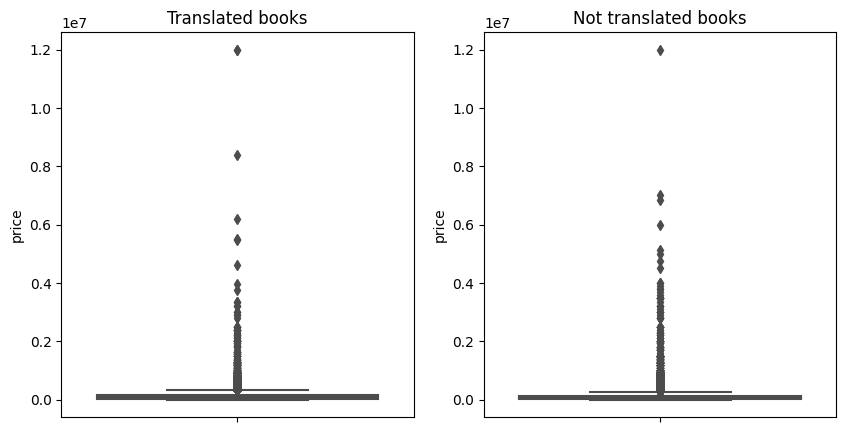

In [223]:
# Create boxplot to have a better understanding of the data specially outliers

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.boxplot(y="price", data=df_translated, ax=axes[0], color="blue")
axes[0].set_title("Translated books")
sns.boxplot(y="price", data=df_not_translated, ax=axes[1], color="red")
axes[1].set_title("Not translated books")

In [224]:
# Define a function to remove outliers based on IQR

def remove_outliers(df, column_name="price", threshold=0.95):
    Q1 = df[column_name].quantile(1 - threshold)
    Q3 = df[column_name].quantile(threshold)
    IQR = Q3 - Q1

    # lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_df = df[(df[column_name] <= upper_bound)]

    return filtered_df

In [225]:
# Flagging wether to remove outliers or not
# If True, remove outliers based on which threshold

outlier_removal_1 = False

# True for Threshold %95
# False for Threshold %75
outlier_threshold_1 = False

In [226]:
# Implement final dataframe to analyze
# based on the decision to remove outliers or not, and with which threshold

if outlier_removal_1:
    if outlier_threshold_1:
        df_tr = remove_outliers(df_translated, threshold=0.95)
        df_ntr = remove_outliers(df_not_translated, threshold=0.95)
    else:
        df_tr = remove_outliers(df_translated, threshold=0.75)
        df_ntr = remove_outliers(df_not_translated, threshold=0.75)
else:
    df_tr = df_translated
    df_ntr = df_not_translated

In [227]:
# Define a function to plot a histogram for each dataframe
# to check the distribution of the data, their normality, & their means

def create_double_histogram(df1, df2, df1_label, df2_label, title, column_name="price"):
    mean_1 = df1[column_name].mean()
    mean_2 = df2[column_name].mean()

    plt.figure(figsize=(7, 5))
    sns.histplot(data=df1, x=column_name, color="blue", kde=True, label=df1_label)
    sns.histplot(data=df2, x=column_name, color="red", kde=True, label=df2_label)

    mean_text_y = plt.ylim()[1] / 2

    plt.axvline(mean_1, color="blue", linestyle="--")
    plt.text(mean_1, mean_text_y, f"{mean_1:,.2}", rotation=0, color="blue")

    plt.axvline(mean_2, color="red", linestyle="--")
    plt.text(mean_2, mean_text_y + 50, f"{mean_2:,.2}", rotation=0, color="red")

    plt.title(title, loc="center")
    plt.legend()
    plt.tight_layout()
    plt.show()

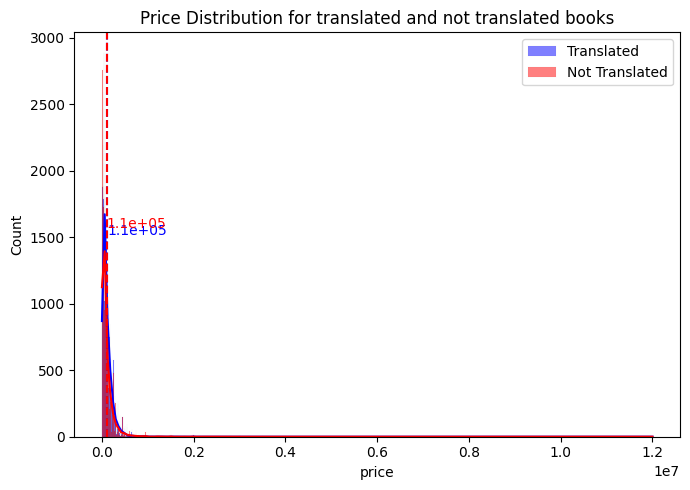

In [228]:
# Plot the histogram for the final dataframes

create_double_histogram(
    df_tr,
    df_ntr,
    "Translated",
    "Not Translated",
    title="Price Distribution for translated and not translated books",
)

In [229]:
# Measure skewness for both groups

skewness_translated = df_tr["price"].skew()
skewness_not_translated = df_ntr["price"].skew()

print(f"Skewness for translated books: {skewness_translated:,.2f}")
print(f"Skewness for not-translated books: {skewness_not_translated:,.2f}")

Skewness for translated books: 23.45
Skewness for not-translated books: 15.98


> Both are right-skewed <br>
> \> We will go on applying **BOXCOX** transformation <br>
>   Box-Cox was chosen because it can stabilize variance and transform data towards normality, optimizing the transformation based on the data itself.

Skewness for translated books after boxcox transform: 0.02
Skewness for not-translated books after boxcox transform: 0.00


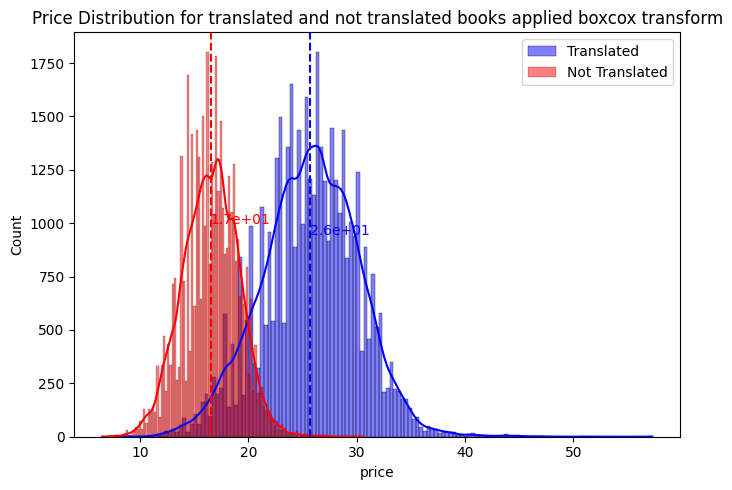

In [230]:
# If skewness is significant, apply BOXCOX transformation

skewed = True

if skewed:
    # Apply BOXCOX transformation for both groups
    df_tr["price"], _ = boxcox(df_tr["price"])
    df_ntr["price"], _ = boxcox(df_ntr["price"])

    skewness_translated = df_tr["price"].skew()
    skewness_not_translated = df_ntr["price"].skew()

    print(f"Skewness for translated books after boxcox transform: {skewness_translated:,.2f}")
    print(f"Skewness for not-translated books after boxcox transform: {skewness_not_translated:,.2f}")

    create_double_histogram(
        df_tr,
        df_ntr,
        "Translated",
        "Not Translated",
        title="Price Distribution for translated and not translated books applied boxcox transform",
        column_name="price",
    )

In [231]:
# Perform independent two-sample t-test

translated_prices = df_tr["price"]
not_translated_prices = df_ntr["price"]

t_stat, p_value = ttest_ind(translated_prices, not_translated_prices)

print(f"T-statistic: {t_stat:,.5f}")
print(f"P-value: {p_value:,.5f}")

T-statistic: 364.15948
P-value: 0.00000


In [232]:
# Double check for outliers using Yuen's t-test
# :: trimming elements from each tail with fraction of 0.4

t_stat_trim, p_value_trim = ttest_ind(translated_prices, not_translated_prices, trim=0.4)

print(f"Trimmed T-statistic: {t_stat_trim:,.5f}")
print(f"Trimmed P-value: {p_value_trim:,.5f}")

Trimmed T-statistic: 315.34078
Trimmed P-value: 0.00000


> A  p-value of **0.000** and a **high** value for t_stat indicates that the observed data is extremely inconsistent with the null hypothesis. <br>
> This leads to the **REJECTION** of the null hypothesis(H<sub>0</sub>) in favor of the alternative hypothesis (H<sub>a</sub>). <br>
> *This suggests that, based on the sample data, there is very strong evidence to conclude that translation has a significant impact on the book's price.*

------------------------------------------------

## 5. Hypothesis #2
### “There is a significant difference in prices between 'Hard' and ‘Shomiz’ book covers.”

Null Hypothesis (H<sub>0</sub>): There is no difference in the mean prices between 'Hard' and 'Shomiz' book covers. <br>
Alternative Hypothesis (H<sub>1</sub>): There is a difference in the mean prices between 'Hard' and 'Shomiz' book covers.

In [233]:
# Read from MySQL database

df_hard, df_shomiz = rd.hypothesis_two()

df_hard.head(), df_shomiz.head()

/Users/kvmmn/Desktop/data_summit/quda/quda_projects/Book-Store/kaveh_analysis/required_dataframes.py:187: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hard_cover_df = pd.read_sql(query, conn)
/Users/kvmmn/Desktop/data_summit/quda/quda_projects/Book-Store/kaveh_analysis/required_dataframes.py:195: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  shomiz_cover_df = pd.read_sql(query, conn)


(     code    price   cover
 0   44167  8400000  جلدسخت
 1  114978  8400000  جلدسخت
 2  114624  8000000  جلدسخت
 3   62672  6200000  جلدسخت
 4  116285  6000000  جلدسخت,
     code    price  cover
 0  35689  7000000  شومیز
 1    132  3350000  شومیز
 2  70474  3000000  شومیز
 3  98525  2930000  شومیز
 4  19455  2900000  شومیز)

In [234]:
# Remove unnecessary columns

df_hard = df_hard[['price']]
df_shomiz = df_shomiz[['price']]

Text(0.5, 1.0, 'Price Distribution for "Shomiz" books')

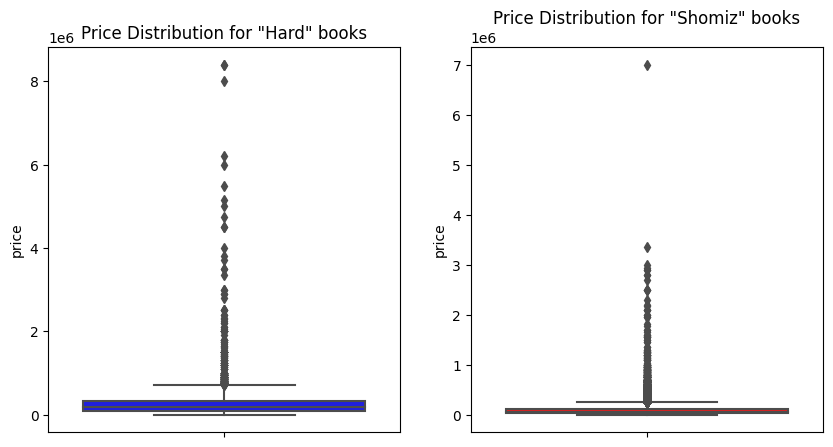

In [235]:
# Create boxplot to have a better understanding of the data specially outliers

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.boxplot(y="price", data=df_hard, ax=axes[0], color="blue")
axes[0].set_title('Price Distribution for "Hard" books')

sns.boxplot(y="price", data=df_shomiz, ax=axes[1], color="red")
axes[1].set_title('Price Distribution for "Shomiz" books')

In [236]:
# Flagging wether to remove outliers or not
# If True, remove outliers based on which threshold

outlier_removal_2 = False

# True for Threshold %95
# False for Threshold %75
outlier_threshold_2 = False

In [237]:
# Implement final dataframe to analyze
# based on the decision to remove outliers or not, and with which threshold

if outlier_removal_2:
    if outlier_threshold_2:
        df_hard = remove_outliers(df_hard, threshold=0.95)
        df_shomiz = remove_outliers(df_shomiz, threshold=0.95)
    else:
        df_hard = remove_outliers(df_hard, threshold=0.75)
        df_shomiz = remove_outliers(df_shomiz, threshold=0.75)
else:
    pass

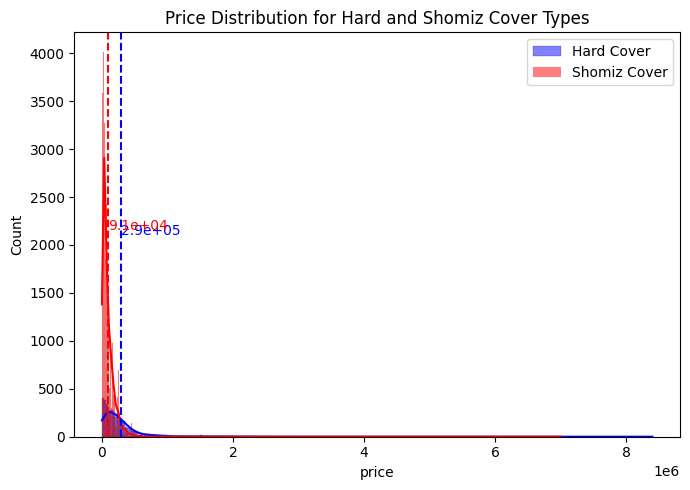

In [238]:
# Plot the histogram for the final dataframes

create_double_histogram(
    df_hard,
    df_shomiz,
    "Hard Cover",
    "Shomiz Cover",
    title="Price Distribution for Hard and Shomiz Cover Types",
)

In [239]:
# Measure skewness for both groups

skewness_hard = df_hard["price"].skew()
skewness_shomiz = df_shomiz["price"].skew()

print(f"Skewness for hard cover books: {skewness_hard:,.2f}")
print(f"Skewness for shomiz cover books: {skewness_shomiz:,.2f}")

Skewness for hard cover books: 8.24
Skewness for shomiz cover books: 9.10


> Both are right-skewed <br>
> \> We will go on applying **BOXCOX** transformation <br>
>   Box-Cox was chosen because it can stabilize variance and transform data towards normality, optimizing the transformation based on the data itself.

In [240]:
# If skewness is significant, apply BOXCOX transformation

skewed = False

if skewed:
    # Apply BOXCOX transformation for both groups
    df_hard["price"], _ = boxcox(df_hard["price"])
    df_shomiz["price"], _ = boxcox(df_shomiz["price"])

    skewness_hard = df_hard["price"].skew()
    skewness_shomiz = df_shomiz["price"].skew()

    print(f"Skewness for translated books after boxcox transform: {skewness_hard:,.2f}")
    print(f"Skewness for not-translated books after boxcox transform: {skewness_shomiz:,.2f}")

    create_double_histogram(
        df_hard,
        df_shomiz,
        "Hard Cover",
        "Shomiz Cover",
        title="Price Distribution for Hard & Shomiz Cover After Boxcox Transformation",
        column_name="price",
    )

In [241]:
# Perform independent two-sample t-test

hard_prices = df_hard["price"]
shomiz_prices = df_shomiz["price"]

t_stat, p_value = ttest_ind(hard_prices, shomiz_prices)

print(f"T-statistic: {t_stat:,.5f}")
print(f"P-value: {p_value:,.5f}")

T-statistic: 82.21330
P-value: 0.00000


In [242]:
# Double check for outliers using Yuen's t-test
# :: trimming elements from each tail with fraction of 0.4

t_stat_trim, p_value_trim = ttest_ind(translated_prices, not_translated_prices, trim=0.4)

print(f"Trimmed T-statistic: {t_stat_trim:,.5f}")
print(f"Trimmed P-value: {p_value_trim:,.5f}")

Trimmed T-statistic: 315.34078
Trimmed P-value: 0.00000


> A  p-value of **0.000** and a **high** value for t_stat indicates that the observed data is extremely inconsistent with the null hypothesis. <br>
> This leads to the **REJECTION** of the null hypothesis in favor of the alternative hypothesis. <br>
> *This suggests that, based on the sample data, there is very strong evidence to conclude that there is a significant difference in the mean prices between 'Hard' and 'Shomiz' book covers.*

## Hypothesis 2 :: Justification 1

## Hypothesis 2 :: Justification 2